In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst.plot import *
from skyburst import utils

# Fig 15: Evaluating Starburst over Queueing Policies

In [2]:
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/sched_alg_pareto.log').expanduser()
sched_alg_df = utils.load_logs_as_dataframe(log_path)

In [3]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=3.9, right=4.8)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    
    super_list = [(idx, label, grp) for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values))]
    super_list = [super_list[1], super_list[2], super_list[0]]
    for idx, label, grp in super_list:
        print(label)
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_capacity':
            label = 'Resource-Wait'
        elif label[0] == 'linear_runtime':
            label = 'Runtime-Wait'
            continue
        elif label[0] == 'linear_cost':
            if label[1] == 'fifo':
                label = 'FCFS'
            elif label[1]== 'sjf':
                label = 'SJF'
            elif label[1] == 'edf':
                label = 'EDF'
            else:
                label = 'No'
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis],ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
#     #axs[1].set_xlim(right=36, left=20)
#     lines, labels = ax.get_legend_handles_labels()
# #     fig.legend(lines, labels, ncol=len(labels), \
# #                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
#     fig.legend(lines, labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['sched_alg_x'] == 'fifo' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = '*'
            marker_size = 18
            color='tab:blue'
        if row['sched_alg_x'] == 'sjf' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = 'X'
            marker_size = 13
            color='tab:orange'
        if row['sched_alg_x'] == 'edf' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = 'P'
            marker_size = 13
            color='tab:green'
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)

            
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([Line2D([0], [0], marker='*', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=18, markeredgecolor='tab:blue', label='FSFS'), 
                Line2D([0], [0], marker='X', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=13, markeredgecolor='tab:orange', label='SJF'),
               Line2D([0], [0], marker='P', color='tab:green', markerfacecolor='tab:green', \
            markersize=13, markeredgecolor='tab:green', label='EDF')], labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))            

    plt.tight_layout()
    plt.savefig('figures/evaluation/sched_alg_pareto.pdf', bbox_inches='tight')
    plt.show()  

('linear_cost', 'fifo')
('linear_cost', 'sjf')
('linear_cost', 'edf')


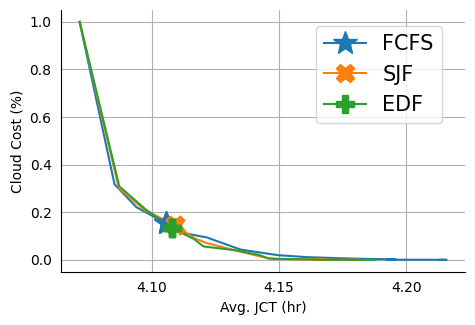

In [4]:
simulator_plotting_fn(sched_alg_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 1,},
                      groupby_values=['waiting_policy', 'sched_alg'],
                      normalize_x_axis=True)

# Fig 15: Evaluating Starburst over Binpacking Policies

In [5]:
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/binpack_pareto.log').expanduser()
binpack_df = utils.load_logs_as_dataframe(log_path)

In [10]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=3.9, right=6)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 

    super_list = [(idx, label, grp) for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values))]
    # super_list = [super_list[1], super_list[2], super_list[0]]
    for idx, label, grp in super_list:
        print(label)
        marker = next(markers)
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_capacity':
            label = 'Resource-Wait'
        elif label[0] == 'linear_runtime':
            label = 'Runtime-Wait'
            continue
        elif label[0] == 'linear_cost':
            if label[1] == 'first-fit':
                label = 'First-Fit'
            elif label[1]== 'best-fit':
                label = 'Best-Fit'
            elif label[1] == 'worst-fit':
                continue
                label = 'Worst-Fit'
            else:
                label = 'No'
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis],ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['binpack_alg_x'] == 'first-fit' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = 'X'
            marker_size = 13
            color='tab:blue'
        if row['binpack_alg_x'] == 'best-fit' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = '*'
            marker_size = 18
            color='tab:orange'
        if row['sched_alg_x'] == 'worst-fit' and row['waiting_factor_x'] == 0.08:
            temp=True
            marker = '*'
            marker_size = 18
            color='tab:green'
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([Line2D([0], [0], marker='X', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='First-Fit'), 
                Line2D([0], [0], marker='*', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=18, markeredgecolor='tab:orange', label='Best-Fit')], labels, ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.92))
    
    plt.tight_layout()
    plt.savefig('figures/evaluation/binpack_pareto.pdf', bbox_inches='tight')
    plt.show()  

('linear_cost', 'best-fit')
('linear_cost', 'first-fit')


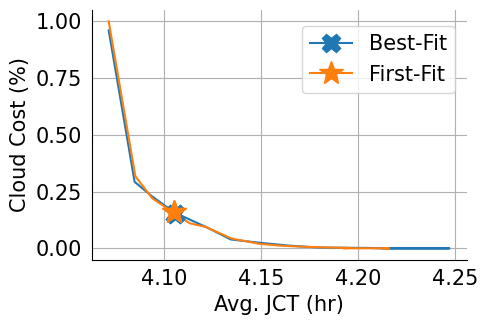

In [11]:
simulator_plotting_fn(binpack_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 1,},
                      groupby_values=['waiting_policy', 'binpack_alg'],
                      normalize_x_axis=True)